## Things to implement: 

- Chi squared offline feature selection [here](https://docs.google.com/presentation/d/1kdqs7pAWWmFbHszl2N6Km-2X7nujMcMH5bu_g9ZGNWQ/edit#slide=id.g190c813b98_3_511)
- Online feature selection [here](https://docs.google.com/presentation/d/1kdqs7pAWWmFbHszl2N6Km-2X7nujMcMH5bu_g9ZGNWQ/edit#slide=id.g190c813b98_3_511)
- NN
- SVM 
- BDT

# Milestone P4: Team KLR - Extending the comparison of classification models for rare civil war onsets

This notebook serves as an extension of Comparing Random Forest with Logistic Regression for Predicting Class-Imbalanced Civil War Onset Data by Muchlinski David, Siroky David, He Jingrui & Kocher Matthew (2016). In similar fashion as Muchlinski et al., 2016, we aim to contribute to the insofar discarded predictive statistical methods in political science, in favor of accurately predicting significant events such as civil wars. To this end, Muchlinski et al., 2016's approach of comparing experimental performance of algorithmic maneuveurs via a multitude of metrics is adopted. However, in contrast with only using Random Forest and near-arbitrarily selecting features, we attempt in our paper to explore and implement additional feature-selection and classification methods through rigorous incorporation of boosting, and a variety of classification algorithms, as well as on and offline feature selection, which benefit an extended, deepened comparison and discussion surrounding not only this imbalanced prediction task, but also the causal estimation of features. While indeed from Muchlinski et al., 2016, it seems that Random Forests drastically outperform their determined competitor in all metrics employed, nuance of their strengths and weaknesses in contrast with more suited models remains uninvestigated, providing justification for extending this analysis.

First, we implement on-and-offline feature selection methods building on Muchlisnki' et al's comparison of Fearon and Latin (2003), Collier and Hoeffler (2004), and Hegre and Sambanis (2006). From which we would like to uncover how feature selection methods serve to aid model performance. The .txt file `notes.txt` contains which variables were used originally by Fearon and Latin (2003), Collier and Hoeffler (2004), and Hegre and Sambanis (2006). We first retrieve these and later compare performance with and without arbitrary feature selection. 

In [1]:
!cat './data/notes.txt'

The main dataset you have to use is `SambnisImp.csv`.
Additionally, the provided `Sambanis Codebook.pdf` file contains a textual
description of (most) used variables.

---

When loading the data for replication purposes, note that the authors only
load the following 91 variables:

    "warstds", "ager", "agexp", "anoc", "army85", "autch98", "auto4",
    "autonomy", "avgnabo", "centpol3", "coldwar", "decade1", "decade2",
    "decade3", "decade4", "dem", "dem4", "demch98", "dlang", "drel", "durable",
    "ef", "ef2", "ehet", "elfo", "elfo2", "etdo4590", "expgdp", "exrec",
    "fedpol3", "fuelexp", "gdpgrowth", "geo1", "geo2", "geo34", "geo57",
    "geo69", "geo8", "illiteracy", "incumb", "infant", "inst", "inst3", "life",
    "lmtnest", "ln_gdpen", "lpopns", "major", "manuexp", "milper", "mirps0",
    "mirps1", "mirps2", "mirps3", "nat_war", "ncontig", "nmgdp", "nmdp4_alt",
    "numlang", "nwstate", "oil", "p4mchg", "parcomp", "parreg", "part",
    "partfree", "plural", "plurrel", "pol4"

In [2]:
# import necessary libraries, define data path, and other hard-coded variables
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, f1_score
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from imblearn.ensemble import BalancedRandomForestClassifier # pip install imblearn - scikit wrapper

DATA_PATH = './data/'
seed = 7

# Extract features used in each paper from notes.txt 
with open(DATA_PATH+'notes.txt') as f:
    
    task_notes = f.readlines()
    task_notes = ''.join(task_notes)
    
    fl_feature_names = re.search(r'(?<=Fearon and Laitin \(2003\):)[^.\.]*',task_notes).group()
    fl_feature_names = re.sub('\n|\s|\"','',fl_feature_names).split(',')
    
    ch_feature_names = re.search(r'(?<=Collier and Hoeffler \(2004\):)[^.\.]*',task_notes).group()
    ch_feature_names = re.sub('\n|\s|\"','',ch_feature_names).split(',')

    hs_feature_names = re.search(r'(?<=Hegre and Sambanis \(2006\):)[^.\.]*',task_notes).group()
    hs_feature_names = re.sub('\n|\s|\"','',hs_feature_names).split(',')
    
    auth_features = re.search(r'(?<=91 variables:)[^.\(]*',task_notes).group()
    auth_features = re.sub('\n|\s|\"','',auth_features).split(',')
    
# load data
master_data = pd.read_csv(DATA_PATH+'SambnisImp.csv', index_col='X')

# split data into features used for each paper and retrieve regressand 
y_master = master_data['warstds']

fl_x = master_data[fl_feature_names]
ch_x = master_data[ch_feature_names]
hs_x = master_data[hs_feature_names]
auth_x = master_data[auth_features]

In [2]:
def compute_roc_vals(X, y, pipeline):
    
    # set seed and ensure input are numpy arrays
    np.random.seed(seed)
    X, y = X.to_numpy(), y.to_numpy()
    
    # If logistic regression, compute best regularization weight and set it
    if 'logisticregression' in pipeline.named_steps:
    
        n_grid_search = 5
        r_lambda = LogisticRegressionCV(Cs = n_grid_search, cv=10, max_iter=10000, scoring='roc_auc', random_state = seed).fit(X, y)
        pipeline['logisticregression'].set_params(C = r_lambda.C_[0], random_state = seed)
        
        # Predict the probabilities with a cross validation
        y_pred = cross_val_predict(pipeline, X, y, cv=10, method='predict_proba')[:,1]
        
        
    if 'randomforestclassifier' or 'balancedrandomforestclassifier' in pipeline.named_steps:
        
        y_pred = cross_val_predict(pipeline, X, y, cv=10, method='predict_proba')[:,1]
    
    if 'svc' in pipeline.named_steps:
        
        pass
        #y_pred = cross_val_predict(pipeline, X, y, cv=10, method='predict')
    
    # Compute the False Positive Rate and True Positive Rate
    fpr, tpr, _ = roc_curve(y, y_pred)
    # Compute the area under the fpr-tpr curve
    auc_score = auc(fpr, tpr)
    # Compute f1 score
    f1 = f1_score(y, (y_pred > 0.5).astype(int)) # how do they get figure 3? i get f1 scores of 0 because the model doesnt predict any civil war onsets..
    
    return fpr, tpr, auc_score, f1

# rewrite this function with seaborn
def roc_plt(fpr, tpr, auc_score):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Area = {:.2f}".format(round(auc_score,2)))
    plt.show()
    
roc_vals={}

First we reproduce the plots from the authors as follows, (can remove later if unnecessary/undesired) - I also dont know how they get f1 scores from these logistic models, given that the f1 score is 0 for multiple of them..

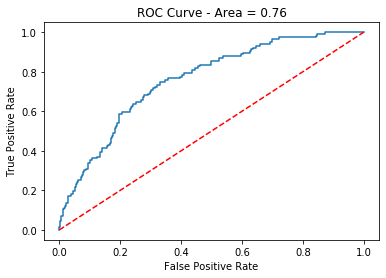

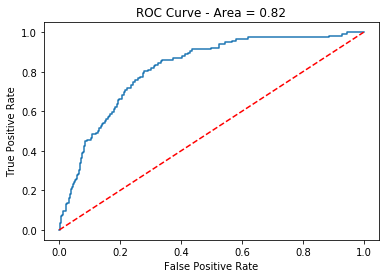

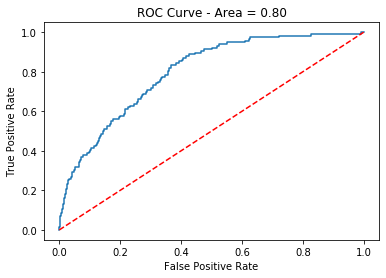

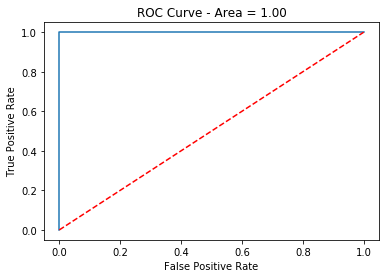

In [3]:
# roc plots for logistic models
log_pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000, penalty='l2'))

roc_vals['log_fl'] = compute_roc_vals(fl_x, y_master, log_pipeline)
roc_vals['log_ch'] = compute_roc_vals(ch_x, y_master, log_pipeline)
roc_vals['log_hs'] = compute_roc_vals(hs_x, y_master, log_pipeline)
roc_vals['log_auth'] = compute_roc_vals(auth_x, y_master, log_pipeline)
roc_plt(*roc_vals['log_fl'][:3])
roc_plt(*roc_vals['log_ch'][:3])
roc_plt(*roc_vals['log_hs'][:3])
roc_plt(*roc_vals['log_auth'][:3])

Interestingly, it seems that the noise from the inclusion of all the variables does not allow the Logistic Model to increase AUC score. The noise is poorly dealt with by the logistic model. Does the RF suffer from the same problem?

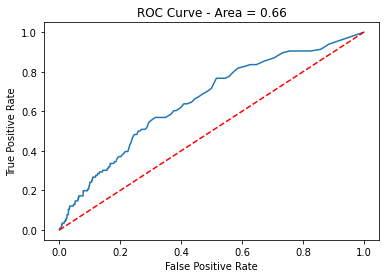

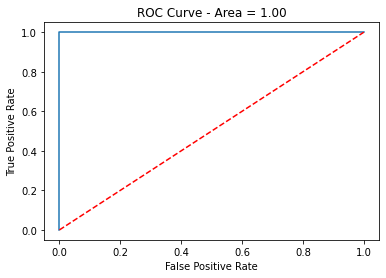

In [10]:
n_trees = 1000
rf_pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=n_trees))
# roc plots for rf without downsampling - fearon laitin variables
roc_vals['rf_fl'] = compute_roc_vals(fl_x, y_master, rf_pipeline)
# roc plots for rf without downsampling - all 90 variables the authors load
roc_vals['rf_auth'] = compute_roc_vals(auth_x, y_master, rf_pipeline)
roc_plt(*roc_vals['rf_fl'][:3])
roc_plt(*roc_vals['rf_auth'][:3])

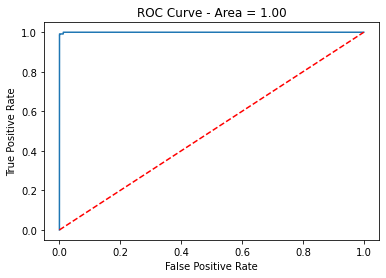

In [11]:
# roc plots for rf with downsampling - all 90 variables the authors load
down_sample_ratio = 1/2
brf_pipeline = make_pipeline(StandardScaler(), BalancedRandomForestClassifier(n_estimators=1000, sampling_strategy = down_sample_ratio))
roc_vals['brf'] = compute_roc_vals(auth_x, y_master, brf_pipeline)
roc_plt(*roc_vals['brf'][:3])

It seems, in fact, that the dataset is simple enough for an AUC score of 1 with barely any hyperparameter optimization, begging the question of which variables the authors' used and how they concluded with a marginally lower AUC score of 0.90. However, this is a first illustration of the ability of the RF to deal with class imbalanced data and steadily deal with the noise unlike the logistic models. Therefore, pinning the importance of feature selection in more simplistic models which cannot filter through the noise. We move on to more suited models (Support vector machines (if this one doesnt work well we can move on to another model), Boosted Decision Trees, and Neural Networks). 

## II SVM 

In [3]:
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

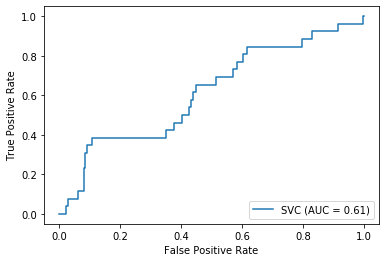

In [21]:
class_weight = {0:1, 1:50}
penalty = .01 # technically inverse of regularization
kernel = 'poly' #possible: linear, poly, rbf, sigmoid, precomputed 
seed = 0

# working auc roc for svm - can harmonize it with the rest of the notebook once i know how you guys want to approach this
X_train, X_test, y_train, y_test = train_test_split(auth_x, y_master, random_state=seed)
clf = SVC(random_state=0, class_weight=class_weight, C=penalty, kernel=kernel)
# when i scale i get auc = 1 - does this make sense?
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)
clf.fit(X_train, y_train)
SVC(random_state=seed)
plot_roc_curve(clf, X_test, y_test)  
plt.show()                                   

## III Boosted Decision Trees

Random Forest and Boosted Decision Trees both are based on Decision Trees to make predictions. However, Random Forest uses **Bagging**, which relies on training learners in parallel on different samples of the data and then combining by voting (discrete output) or by averaging (continuous output). It is really easy to implement and to parallelize (and therefore one of the most popular classifier for dense data). Whereas Boosted Decision Trees uses **Boosting**, which relies on training learner again, but after filtering/weighting samples based on output of previous train/test runs. In contrast to Random Forest, here the trees are trained independently as they are trained sequentially by boosting (meaning that each tree is trained to predict error residuals of previous trees). This technic allows to reduce the bias.

After many researches on the internet [citation needed](citationlink), we found that actually **Random Forest is not really suited for classification problems with a skewed class distribution**. However, according to the literature [citation needed](citationlink), Boosted Decision Trees seems less sensitive to such imbalanced dataset. This is why we will implement it and test this hypothesis.

### 1) Kind of Boosted Decision Trees?

`sklearn` offers such a Boosting Decision Trees classifier: `AdaBoostClassifer`. 

Here is a bit of knowledge about AdaBoost : "The core principle of AdaBoost is to **fit a sequence of weak learners** (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data. The predictions from all of them are then combined through a **weighted majority vote** (or sum) to produce the final prediction. The data modifications at each so-called **boosting iteration consist of applying weights $w_i$ to each of the training samples**. Initially, those weights are all set to $w_i = 1/N$ so that the first step simply trains a weak learner on the original data. For each successive iteration, the sample weights are individually modified and the learning algorithm is reapplied to the reweighted data. At a given step, **those training examples that were incorrectly predicted by the boosted model induced at the previous step have their weights increased, whereas the weights are decreased for those that were predicted correctly**. As iterations proceed, **examples that are difficult to predict receive ever-increasing influence**. Each subsequent weak learner is thereby forced to concentrate on the examples that are missed by the previous ones in the sequence"

With this, we understand clearly here why this kind of Boosted Decision Trees has better chance to handle imbalanced dataset. Civil War Onsets being really rare and hard to predict events, it will receive an ever-increasing influence through the weights until it balances out the fact that they are rare in the dataset. This why, we can hope that the model will be better suited (than RF) to predict these kind of events as it will be forced to concentrate on these hard to detected (because rare) events missed by the previous trees.

### 2) Libraries

In [3]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

### 3) Pre-processing

In [4]:
##load the data 

target = auth_x['warstds']
features = auth_x.drop('warstds', axis = 1)

In [5]:
means = features.mean()
stds = features.std()

for c in features.columns:
    features[c] = (features[c] - means[c])/stds[c]
    
display(features)

,ager,agexp,anoc,army85,autch98,auto4,autonomy,avgnabo,centpol3,coldwar,...,seceduc,second,semipol3,sip2,sxpnew,sxpsq,tnatwar,trade,warhist,xconst
X,,,,,,,,,,,,,,,,,,,,,
1,0.011565,-0.075864,-0.503682,-0.097323,0.016433,-0.005731,-0.018215,-0.053497,0.411715,0.556820,...,0.076855,0.919162,-0.007550,0.026881,0.094095,0.052437,-0.139284,0.107157,-0.454154,0.033310
2,0.008046,-0.079254,-0.503682,-0.097473,0.016433,1.775804,-0.082597,-1.315951,0.411715,0.556820,...,0.069821,0.919162,-0.287012,-1.219573,0.094547,0.049137,0.509491,0.107596,-0.454154,-1.298861
3,1.308743,-0.079039,-0.503682,-0.094927,0.016433,1.775804,-0.082597,-1.364826,0.411715,0.556820,...,0.067881,0.919162,-0.287012,-1.219573,0.095567,0.051447,1.674799,0.109070,-0.454154,-1.298861
4,1.339237,-0.082167,-0.503682,-0.104053,0.016433,1.775804,-0.082597,-1.389263,0.411715,0.556820,...,0.066018,0.919162,-0.287012,-1.219573,0.101303,0.051559,1.674799,0.112345,-0.454154,-1.298861
5,1.369731,-0.077000,-0.503682,-0.093556,0.016433,1.775804,-0.082597,-1.389263,0.411715,0.556820,...,0.070357,0.919162,-0.287012,-1.219573,0.092107,0.049569,1.674799,0.106430,-0.454154,-1.298861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9628,-0.093999,-0.262238,-0.503682,-0.306074,0.016433,0.602620,-0.082597,0.334757,0.411715,-1.795662,...,0.213322,0.415169,-0.007124,-0.254582,0.259141,-0.174152,-0.655817,0.250157,-0.454154,-0.409535
9629,-0.063505,-0.170693,-0.503682,-0.306074,0.016433,0.602620,-0.082597,0.334757,0.411715,-1.795662,...,0.213322,0.415169,-0.006284,-0.254582,0.452436,-0.100702,-0.655817,0.103778,-0.454154,-0.409535
9630,-0.033010,0.145460,-0.503682,-0.306074,0.016433,0.602620,-0.082597,0.334757,0.411715,-1.795662,...,0.213322,0.415169,-0.006889,-0.254582,0.097356,0.050272,-0.655817,0.256251,-0.454154,-0.409535


### 4) Tuning hyperparameters: Cross-validation

AdaBoostmodel depends on an hyperparameter `nt`(number of estimators, i.e. decision trees). We will now tune it using Cross-validation.

In [9]:
def plot_precision_recall_nt(number_trees):
    precision_scores = []
    recalls_scores = []
    #accuracy_scores = []

    for nt in number_trees:
        print(nt)
        clf = AdaBoostClassifier(n_estimators=nt, random_state=0)
        precision = cross_val_score(clf, features, target, cv=10, scoring="precision")
        precision_scores.append(precision.mean())
        recall = cross_val_score(clf, features, target, cv=10, scoring="recall")
        recalls_scores.append(recall.mean())
        #accuracy = cross_val_score(clf, features, target, cv=10, scoring="accuracy")
        #accuracy_scores.append(accuracy.mean())
    
    return precision_scores, recalls_scores

In [6]:
precision_scores, recalls_scores = plot_precision_recall_nt([50, 100, 250, 500, 750, 1000])

50
100
250
500
750
1000


Note here that it would be tempting to compute accuracy, but that this measures is meaningless in such a imbalanced dataset.

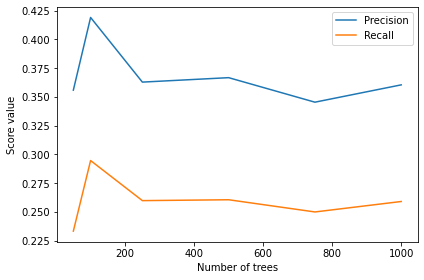

In [7]:
fig, ax = plt.subplots(1,figsize=(6,4))

ax.plot(number_trees, precision_scores, label="Precision")
ax.plot(number_trees, recalls_scores, label="Recall")

ax.set_ylabel("Score value")
ax.set_xlabel("Number of trees")
ax.legend()

fig.tight_layout()

Precision as well as Recall seems higher around 100 estimators. Let's plot this again for nt in that range.

In [10]:
precision_scores, recalls_scores = plot_precision_recall_nt([70,80,90,100,110,120,130,140,150,160])

70
80
90
100
110
120
130
140
150
160


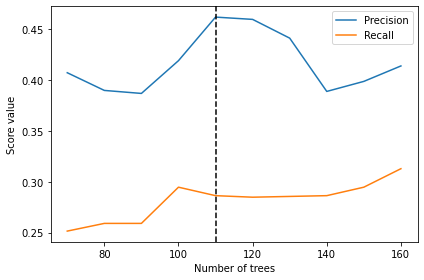

In [18]:
fig, ax = plt.subplots(1,figsize=(6,4))
number_trees = [70,80,90,100,110,120,130,140,150,160]
ax.plot(number_trees, precision_scores, label="Precision")
ax.plot(number_trees, recalls_scores, label="Recall")
ax.axvline(x=110, c = 'black', linestyle = '--')

ax.set_ylabel("Score value")
ax.set_xlabel("Number of trees")
ax.legend()

fig.tight_layout()

**nt = 110** seems to be a good number of trees (by default it's 50). Note that we chose 110 and not 100 because of the massive increase of Precision (which compensate for the negligeable decrease in recall). 

AdaBoostClassifier has another hyperparameter : `base_estimator` which is DecisionTreeClassifier(max_depth=1) by default. We can tune the max_depth via cross-validation.

In [19]:
max_depth = [i for i in range(1,11)]
precision_scores = []
recalls_scores = []
#accuracy_scores = []

nt = 110 #tuned

for depth in max_depth:
    print(depth)
    clf = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = depth), n_estimators=nt, random_state=0)
    precision = cross_val_score(clf, features, target, cv=10, scoring="precision")
    precision_scores.append(precision.mean())
    recall = cross_val_score(clf, features, target, cv=10, scoring="recall")
    recalls_scores.append(recall.mean())
    #accuracy = cross_val_score(clf, features, target, cv=10, scoring="accuracy")
    #accuracy_scores.append(accuracy.mean())

1
2
3
4
5
6
7


/home/loic/anaconda3/envs/ada/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/loic/anaconda3/envs/ada/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8


/home/loic/anaconda3/envs/ada/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/loic/anaconda3/envs/ada/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9


/home/loic/anaconda3/envs/ada/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10


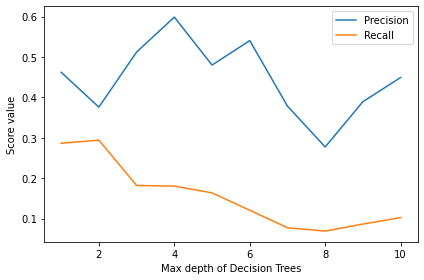

In [20]:
fig, ax = plt.subplots(1,figsize=(6,4))

ax.plot(max_depth, precision_scores, label="Precision")
ax.plot(max_depth, recalls_scores, label="Recall")

ax.set_ylabel("Score value")
ax.set_xlabel("Max depth of Decision Trees")
ax.legend()

fig.tight_layout()

Here we see that the bigger the max_depth, the bigger the Precision but the lower the Recall. We have to think about what's best for our application. Should we care more about Precision or about Recall? And to what extend? After testing with different number of trees, we obtain better ROC curves with 4 and thus will keep this value.

AdaBoostClassifier has another hyperparameter : `learning_rate`. We can tune the max_depth via cross-validation.

In [49]:
learning_rates = [0.1,0.5,1,1.5,2,5]
precision_scores = []
recalls_scores = []
#accuracy_scores = []

nt = 110 #tuned
depth = 4 #tuned

for learning_rate in learning_rates:
    print(learning_rate)
    clf = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = depth), n_estimators=nt, random_state=0, learning_rate=learning_rate)
    precision = cross_val_score(clf, features, target, cv=10, scoring="precision")
    precision_scores.append(precision.mean())
    recall = cross_val_score(clf, features, target, cv=10, scoring="recall")
    recalls_scores.append(recall.mean())
    #accuracy = cross_val_score(clf, features, target, cv=10, scoring="accuracy")
    #accuracy_scores.append(accuracy.mean())

0.1
0.5
1
1.5
2


/home/loic/anaconda3/envs/ada/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5


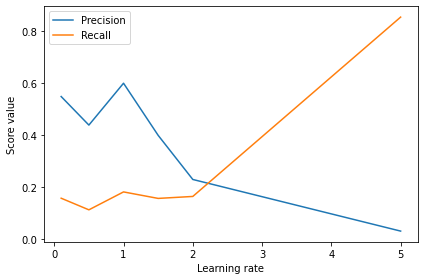

In [53]:
fig, ax = plt.subplots(1,figsize=(6,4))

ax.plot(learning_rates, precision_scores, label="Precision")
ax.plot(learning_rates, recalls_scores, label="Recall")


ax.set_ylabel("Score value")
ax.set_xlabel("Learning rate")
ax.legend()

fig.tight_layout()

Here we see that the best performance is obtained for the learning rate = 1 (by default). Note that there exists obviously a trade-off between learning_rate and n_estimators.

### 5) Comparing the models: ROC curves

Now that we have tuned our AdaBoostClassifier, we will compare its performances to the other classifiers using ROC curves

In [44]:
nt = 110 #tuned
AdaBoostmodel = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=4), n_estimators=nt, random_state = 1)

We will first make target predictions using cross-validation.

In [45]:
target_prediction_AdaBoostmodel = cross_val_predict(AdaBoostmodel, features, target, cv = 10, method="predict_proba")

Then use the result to compute its ROC curve:

In [50]:
FPR_AdaBoostmodel, TPR_AdaBoostmodel, thresholds = roc_curve(target, target_prediction_AdaBoostmodel[:, 1])

We will also compute its AUC score:

In [51]:
AUC_AdaBoostmodel = auc(FPR_AdaBoostmodel, TPR_AdaBoostmodel)

And now plot it:

Text(0.5, 1.0, 'AdaBoostClassifier ROC curve')

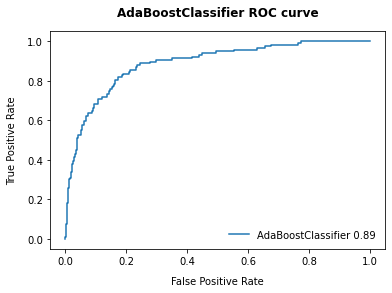

In [48]:
plt.plot(FPR_AdaBoostmodel, TPR_AdaBoostmodel, label = "AdaBoostClassifier {:.2f}".format(AUC_AdaBoostmodel))
plt.legend(frameon = False)
plt.xlabel("False Positive Rate", labelpad = 10)
plt.ylabel("True Positive Rate", labelpad = 10)
plt.title("AdaBoostClassifier ROC curve", pad = 15, fontweight = 'bold')

Here is the Random Forest's ROC curve:

<img src="./pictures/Random_forest_ROC_curve.png" width="425"/>

As expected, our AdaBoostClassifier scores better than any of the Logistic Regression methods, but a bit worse than Random Forest.

F1 score + features importance